# 기본 데이터셋 불러오기

In [34]:
import pandas as pd

train_df = pd.read_csv('./data_base/train.csv')
test_df = pd.read_csv('./data_base/test.csv')

# EDA 및 전처리

In [35]:
train_df.isnull().sum()

user_id                              0
subscription_duration                0
recent_login_time                    0
average_login_time                   0
average_time_per_learning_session    0
monthly_active_learning_days         0
total_completed_courses              0
recent_learning_achievement          0
abandoned_learning_sessions          0
community_engagement_level           0
preferred_difficulty_level           0
subscription_type                    0
customer_inquiry_history             0
payment_pattern                      0
target                               0
dtype: int64

In [36]:
train_df.head()
# user_id -> 삭제 필요

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


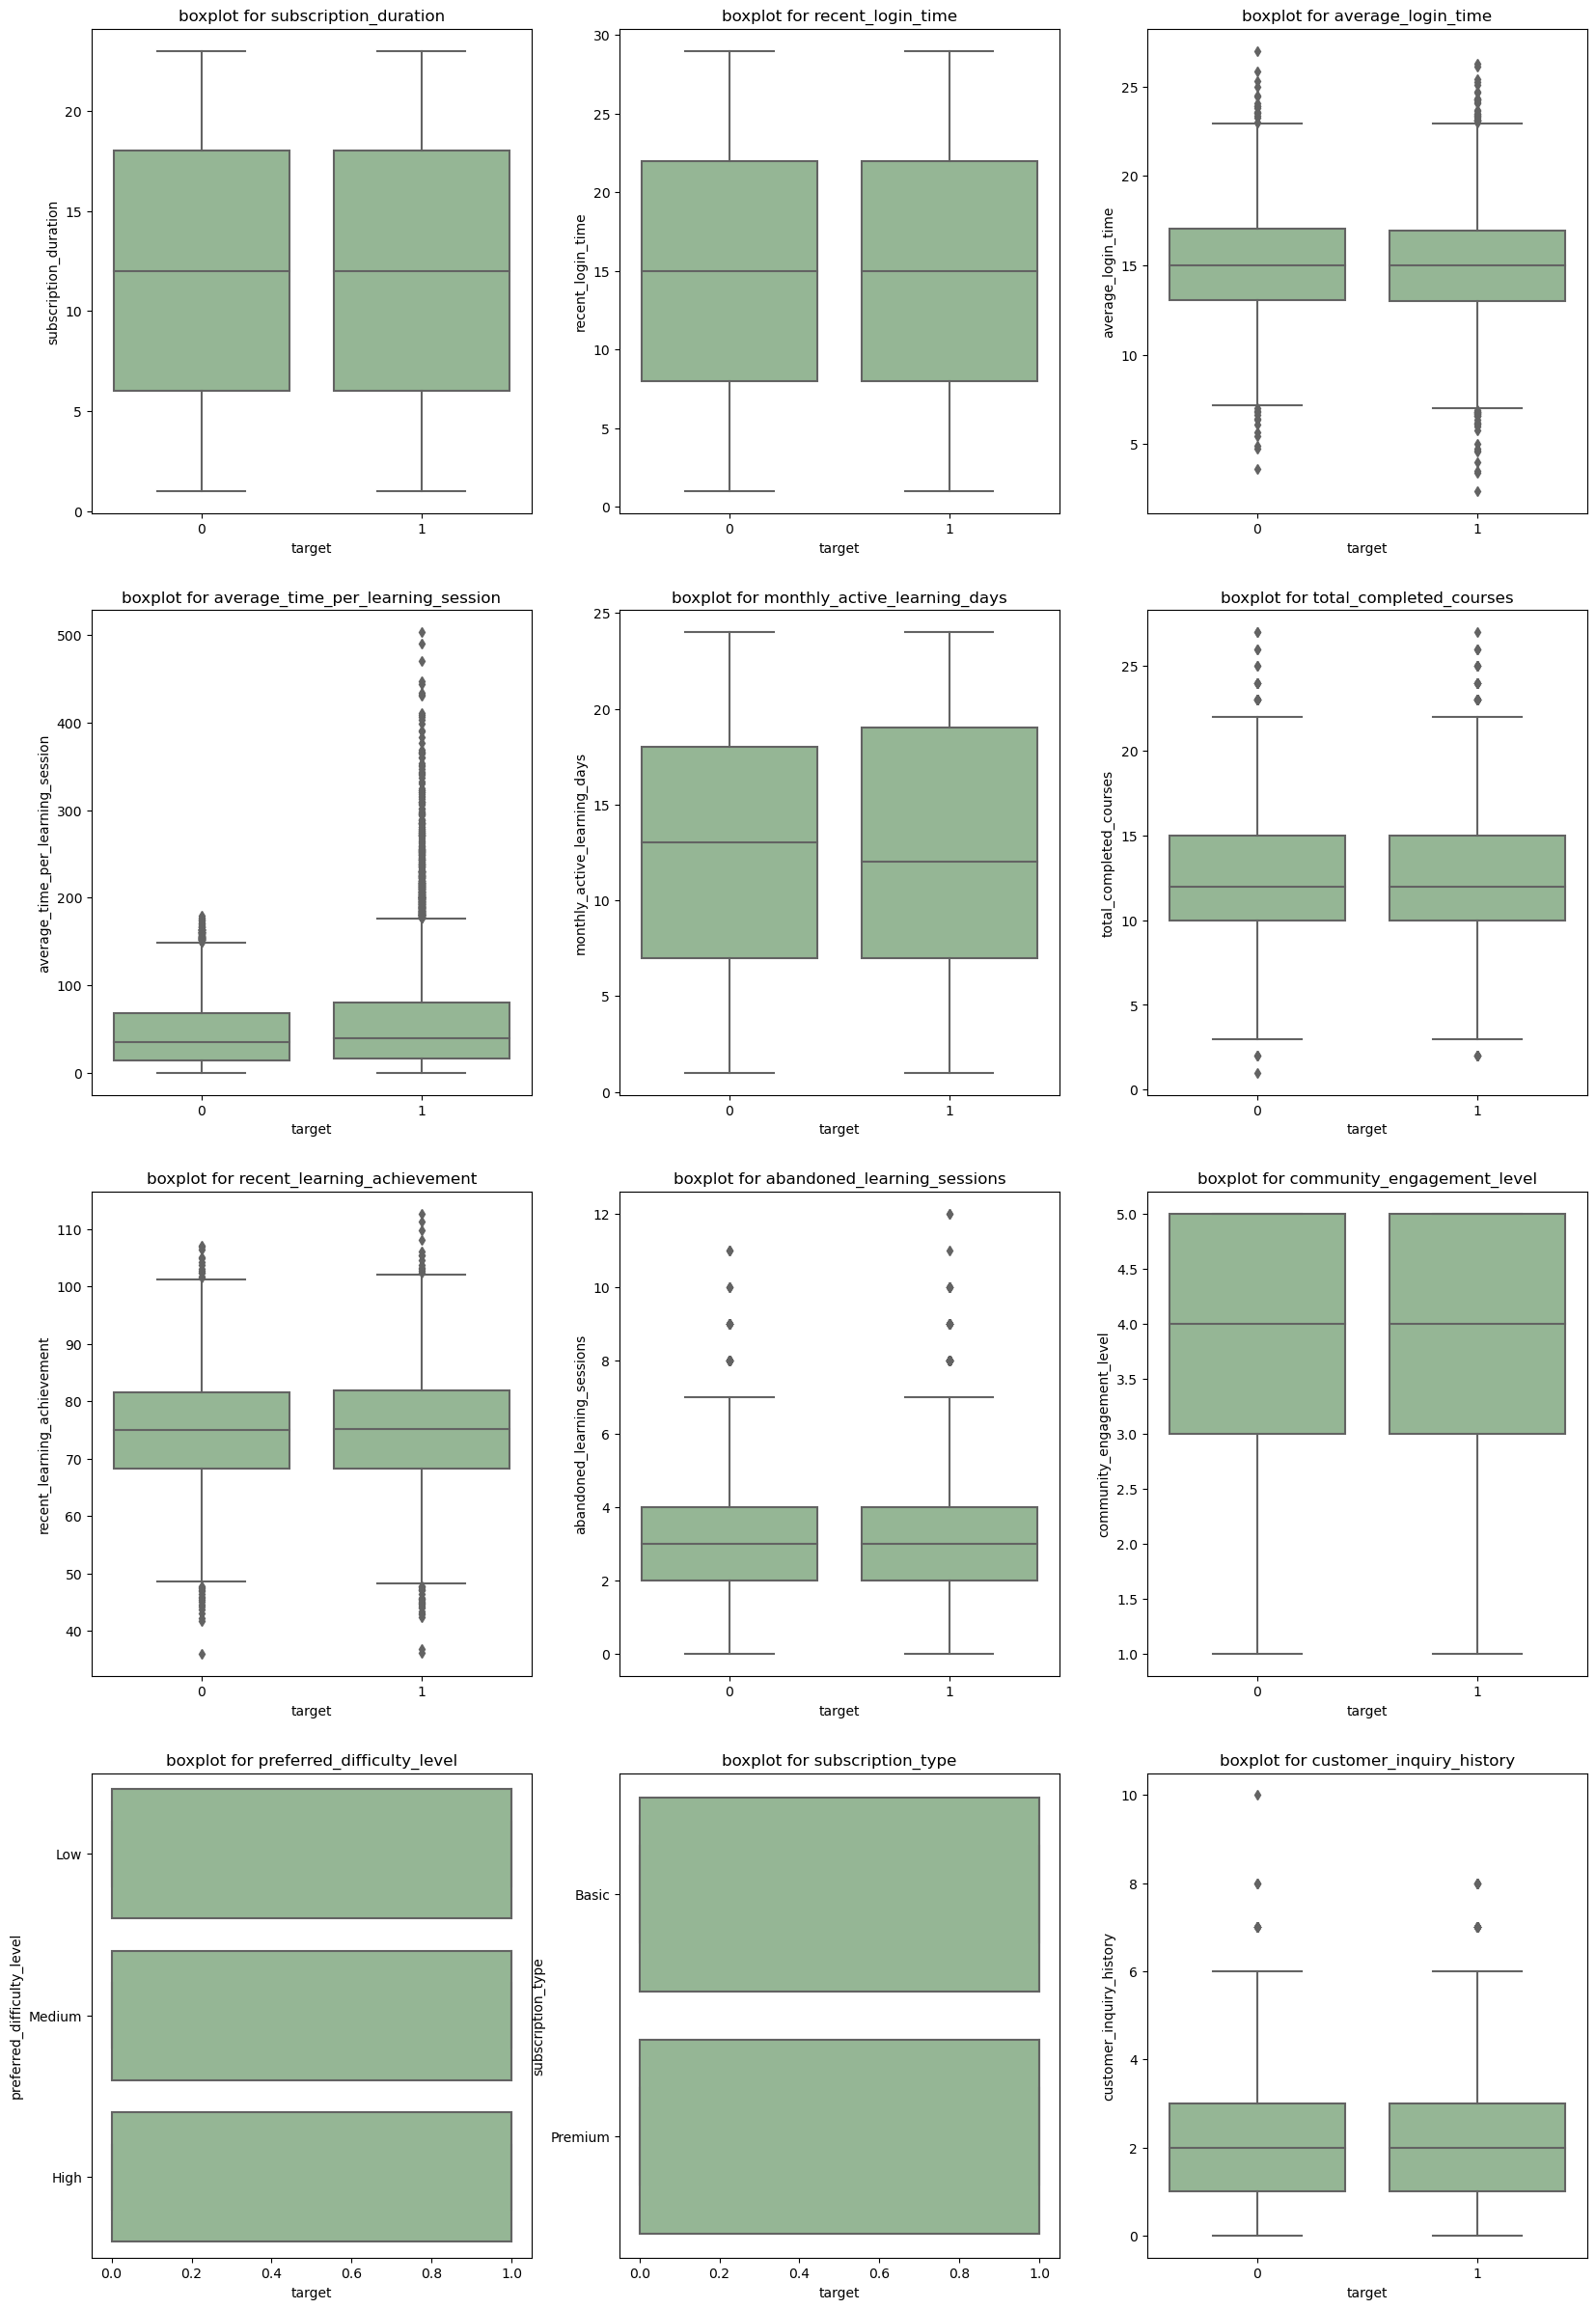

<Figure size 640x480 with 0 Axes>

In [37]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(4,3, figsize = (20,30))

for idx,col in enumerate(train_df.columns[1:13]):
    # 서브플랏 위치 지정
    row_index = idx // 3
    col_index = idx % 3

    sns.boxplot(x = train_df['target'],y = train_df[col], color = 'darkseagreen', ax = ax[row_index,col_index])
    ax[row_index,col_index].set_title('boxplot for %s' % col)
plt.show()

# 레이아웃 조정
plt.tight_layout(pad=5)
plt.subplots_adjust(wspace=0, hspace=5)

### 이상치 처리

#### 이상치 제거 : IQR

In [38]:
train_df['customer_inquiry_history'].index

RangeIndex(start=0, stop=10000, step=1)

In [39]:
# outlier 찾기

weight = 1.5
Q1 = train_df['customer_inquiry_history'].quantile(0.25)
Q3 = train_df['customer_inquiry_history'].quantile(0.75)
IQR = Q3-Q1
max_value = Q3 + (IQR * weight)
min_value = Q1 - (IQR * weight)

outlier = []
outlier_index = []
for i in train_df['customer_inquiry_history'].index:
    value = train_df['customer_inquiry_history'][i]

    if value > max_value or value < min_value:
        outlier.append(value)       
        outlier_index.append(i)

In [40]:
def outlier_feature(dataFrame):
    numerical_cols = [col for col in dataFrame.columns if dataFrame[col].dtype in ['int64', 'float64'] and col not in ['target']]
    
    outlier = []
    outlier_index = []
    
    for column in numerical_cols:
        # 칼럼별 이상치 범위 계산
        weight = 1.5
        Q1 = dataFrame[column].quantile(0.25)
        Q3 = dataFrame[column].quantile(0.75)
        IQR = Q3-Q1
        max_value = Q3 + (IQR * weight)
        min_value = Q1 - (IQR * weight)

        # 칼럼별 이상치 여부 확인 후 인덱스 담기
        for i in dataFrame[column].index:
            value = dataFrame[column][i]

            if value > max_value or value < min_value:
                outlier.append(value)       
                outlier_index.append(i)
                
    # 칼럼별 이상치가 있는 행 인덱스 중복 제거
    outlier_index = list(set(outlier_index))
    
    # 이상치 있는 행 제거
    dataFrame.drop(outlier_index, axis=0, inplace=True)
        
    return dataFrame

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

# 데이터 전처리 정리

In [42]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder    
        
def preprocessing_df(train_df, test_df):
    # 'user_id' 칼럼 삭제
    train_df.drop('user_id',axis=1,inplace=True)
    test_df.drop('user_id',axis=1,inplace=True)
 
    # 데이터 타입에 따라 칼럼 구분
    object_cols = train_df.select_dtypes(include='object')
    numerical_cols = [col for col in train_df.columns if train_df[col].dtype in ['int64', 'float64'] and col not in ['target']]
      
    # 이상치 제거 함수 적용
    train_df = outlier_feature(train_df)
        
    # 숫자형 -> StandardScaling
    scaler = StandardScaler()
    scaler = scaler.fit(train_df[numerical_cols])
    train_df[numerical_cols] = scaler.transform(train_df[numerical_cols])
    test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])
    
    # 문자형 -> LabelEncoding
    for column in object_cols.columns:
        le = preprocessing.LabelEncoder()
        le = le.fit(train_df[column])
        train_df[column] = le.transform(train_df[column])
        test_df[column] = le.transform(test_df[column])
        
    
    return train_df, test_df    


In [43]:
train_df, test_df = preprocessing_df(train_df,test_df)

In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9115 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   subscription_duration              9115 non-null   float64
 1   recent_login_time                  9115 non-null   float64
 2   average_login_time                 9115 non-null   float64
 3   average_time_per_learning_session  9115 non-null   float64
 4   monthly_active_learning_days       9115 non-null   float64
 5   total_completed_courses            9115 non-null   float64
 6   recent_learning_achievement        9115 non-null   float64
 7   abandoned_learning_sessions        9115 non-null   float64
 8   community_engagement_level         9115 non-null   float64
 9   preferred_difficulty_level         9115 non-null   int64  
 10  subscription_type                  9115 non-null   int64  
 11  customer_inquiry_history           9115 non-null   float64
 1

In [45]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   subscription_duration              10000 non-null  float64
 1   recent_login_time                  10000 non-null  float64
 2   average_login_time                 10000 non-null  float64
 3   average_time_per_learning_session  10000 non-null  float64
 4   monthly_active_learning_days       10000 non-null  float64
 5   total_completed_courses            10000 non-null  float64
 6   recent_learning_achievement        10000 non-null  float64
 7   abandoned_learning_sessions        10000 non-null  float64
 8   community_engagement_level         10000 non-null  float64
 9   preferred_difficulty_level         10000 non-null  int64  
 10  subscription_type                  10000 non-null  int64  
 11  customer_inquiry_history           10000 non-null  floa

# 머신러닝

In [46]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

* 기본 머신러닝

In [47]:
y_train = train_df['target']
X_train = train_df.drop('target',axis=1)

# 훈련 및 테스트 데이터셋 분리
train_X,test_X,train_y,test_y = train_test_split(X_train,y_train,
                                               test_size=0.2,random_state=11)

# 머신러닝 알고리즘 호출
lr_clf = LogisticRegression(random_state=11)

# 머신러닝 모델 학습
lr_clf.fit(train_X,train_y)

# 기초 성능평가                        
accuracy_lr = accuracy_score(lr_clf.predict(test_X),test_y)
precision_lr = precision_score(lr_clf.predict(test_X),test_y)
recall_lr = recall_score(lr_clf.predict(test_X),test_y)

print(accuracy_lr)
print(precision_lr)
print(recall_lr)

0.578167855183763
1.0
0.578167855183763


* 교차검증

In [48]:
CV_scores_accuaracy = cross_val_score(lr_clf,train_X,train_y,scoring='accuracy',cv=10)
CV_scores_precision = cross_val_score(lr_clf,train_X,train_y,scoring='precision',cv=10)
CV_scores_recall = cross_val_score(lr_clf,train_X,train_y,scoring='recall',cv=10)

print(np.mean(CV_scores_accuaracy))
print(np.mean(CV_scores_precision))
print(np.mean(CV_scores_recall))

0.6060067271736476
0.6060067271736476
1.0


* 하이퍼파라미터 튜닝

In [49]:
params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [50, 100, 200, 500]}
grid_lr_clf = GridSearchCV(lr_clf, param_grid=params, cv=10, refit=True)
grid_lr_clf.fit(X_train,y_train)

scores_df_lr = pd.DataFrame(grid_lr_clf.cv_results_)


/Users/brielle/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/brielle/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/brielle/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brielle/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/

In [50]:
scores_df_lr[['params','mean_test_score','rank_test_score']]

,params,mean_test_score,rank_test_score
0,"{'C': 0.001, 'max_iter': 50, 'penalty': 'l1'}",NaN,21
1,"{'C': 0.001, 'max_iter': 50, 'penalty': 'l2'}",0.600439,1
2,"{'C': 0.001, 'max_iter': 100, 'penalty': 'l1'}",NaN,21
3,"{'C': 0.001, 'max_iter': 100, 'penalty': 'l2'}",0.600439,1
4,"{'C': 0.001, 'max_iter': 200, 'penalty': 'l1'}",NaN,21
5,"{'C': 0.001, 'max_iter': 200, 'penalty': 'l2'}",0.600439,1
6,"{'C': 0.001, 'max_iter': 500, 'penalty': 'l1'}",NaN,21
7,"{'C': 0.001, 'max_iter': 500, 'penalty': 'l2'}",0.600439,1
8,"{'C': 0.01, 'max_iter': 50, 'penalty': 'l1'}",NaN,21
9,"{'C': 0.01, 'max_iter': 50, 'penalty': 'l2'}",0.600439,1


In [51]:
best_params = grid_lr_clf.best_params_
best_model = grid_lr_clf.best_estimator_
print(best_params)
print(best_model)

{'C': 0.001, 'max_iter': 50, 'penalty': 'l2'}
LogisticRegression(C=0.001, max_iter=50, random_state=11)


In [52]:
# 테스트 데이터에 대한 예측 수행
test_X = test_df  # user_id 제외 완료
test_predictions = best_model.predict(test_X)

# 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
sample_submission = pd.read_csv('./data_base/sample_submission.csv')
sample_submission['target'] = test_predictions

# 리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
submit_path = './baseline_submit.csv'
sample_submission.to_csv(submit_path, index=False)

sample_submission.head()

,user_id,target
0,0001d6e9,1
1,0002c77d,1
2,0002df5b,1
3,000b6068,1
4,00184a0c,1
